In [2]:
import torch
import higher
import matplotlib.pyplot as plt
import numpy as np


In [58]:
t = torch.FloatTensor([torch.randint(0, 4, ()) * 0.2 +0.2])
#cov matix is 1,t,t,1
cov = torch.FloatTensor([[1,t],[t,1]])
#h is a 2x1 vector sampled from a complex normal distribution
h = torch.FloatTensor(np.random.multivariate_normal(mean=np.zeros(2), cov=cov, size=2))
h

tensor([[-0.8532, -0.2158],
        [-1.0629, -0.3328]])

In [1]:
from numpy.random import default_rng
from scipy.linalg import sqrtm, dft
import numpy as np

def channel_generation_correlated(Ml, L, N, blk_sz_min, blk_sz_max, R_uniform, lsf):
    rng = default_rng()
    M = Ml * L
    Gamma = np.zeros((N, M))
    Rg = np.zeros((Ml, Ml, N, L))
    Rh = np.zeros((Ml, Ml, N, L))
    H = np.zeros((M, N), dtype=complex)

    Ar = 1 / np.sqrt(Ml) * dft(Ml)
    AR = np.kron(np.eye(L), Ar)

    for l in range(L):
        if Ml == 1:
            minnum = 1
            maxnum = 1
        else:
            minnum = blk_sz_min
            maxnum = blk_sz_max
        r = rng.integers(minnum, maxnum, size=N)
        r1 = rng.integers(0, Ml - maxnum, size=N)
        for k in range(N):
            Gamma[k, (l * Ml + r1[k]):(l * Ml + r1[k] + r[k])] = lsf[k, l]

    for l in range(L):
        for k in range(N):
            gamma = Gamma[k, l * Ml:(l + 1) * Ml]
            Rg[:, :, k, l] = np.diag(np.sqrt(gamma)) @ R_uniform @ np.diag(np.sqrt(gamma))

    for l in range(L):
        for k in range(N):
            Rh[:, :, k, l] = Ar @ Rg[:, :, k, l] @ Ar.conj().T
            H[l * Ml:(l + 1) * Ml, k] = sqrtm(Rh[:, :, k, l]) @ (rng.standard_normal((Ml, 1)) + 1j * rng.standard_normal((Ml, 1))) / np.sqrt(2)

    Ha = AR.conj().T @ H
    Xtilde = Ha.T

    return H, Ha, Xtilde, AR, Rg, Rh

In [62]:
import numpy as np

# Generate a complex random Gaussian standard
complex_gaussian = np.random.normal(0, 1, 10000) + 1j * np.random.normal(0, 1, 10000)

print(complex_gaussian.mean().imag)


-0.007793088602323575


In [42]:
def channel_generation_correlated(Ml, N, R_uniform, lsf):
    rng = default_rng()
    Gamma = np.zeros((N, Ml), dtype=complex)
    Rg = np.zeros((Ml, Ml, N), dtype=complex)
    Rh = np.zeros((Ml, Ml, N), dtype=complex)
    H = np.zeros((Ml, N), dtype=complex)

    Ar = 1 / np.sqrt(Ml) * dft(Ml)

    for k in range(N):
        Gamma[k, :] = lsf[k]
        Rg[:, :, k] = np.diag(np.sqrt(Gamma[k, :])) @ R_uniform @ np.diag(np.sqrt(Gamma[k, :]))
        Rh[:, :, k] = Ar @ Rg[:, :, k] @ Ar.conj().T
        H[:, k] = np.squeeze(sqrtm(Rh[:, :, k]) @ (rng.standard_normal((Ml, 1)) + 1j * rng.standard_normal((Ml, 1))) / np.sqrt(2))

    # Ha = Ar.conj().T @ H

    return H

In [51]:
Ml = 4
N = 3
R_uniform = np.eye(Ml)
lsf = np.random.rand(N, Ml)

# Call the function
H = channel_generation_correlated(Ml, N, R_uniform, lsf)
H

array([[-0.0084397 -0.52961294j,  0.34468739+0.79683129j,
         0.7732184 -0.660649j  ],
       [-0.30025754+0.74581472j, -0.49471114+0.23707147j,
         0.32306186+0.51992748j],
       [-0.16611791-1.23100696j,  0.25996941-0.3030226j ,
         0.2202372 -0.27820327j],
       [-0.55704442+0.36628802j,  0.83023815+0.06618268j,
        -1.08138527+1.14763239j]])

In [63]:
lsf

array([[0.69711371, 0.21546599, 0.62693127, 0.41945958],
       [0.09653267, 0.01936214, 0.03706022, 0.94410044],
       [0.92371153, 0.75455567, 0.78782999, 0.86172002]])

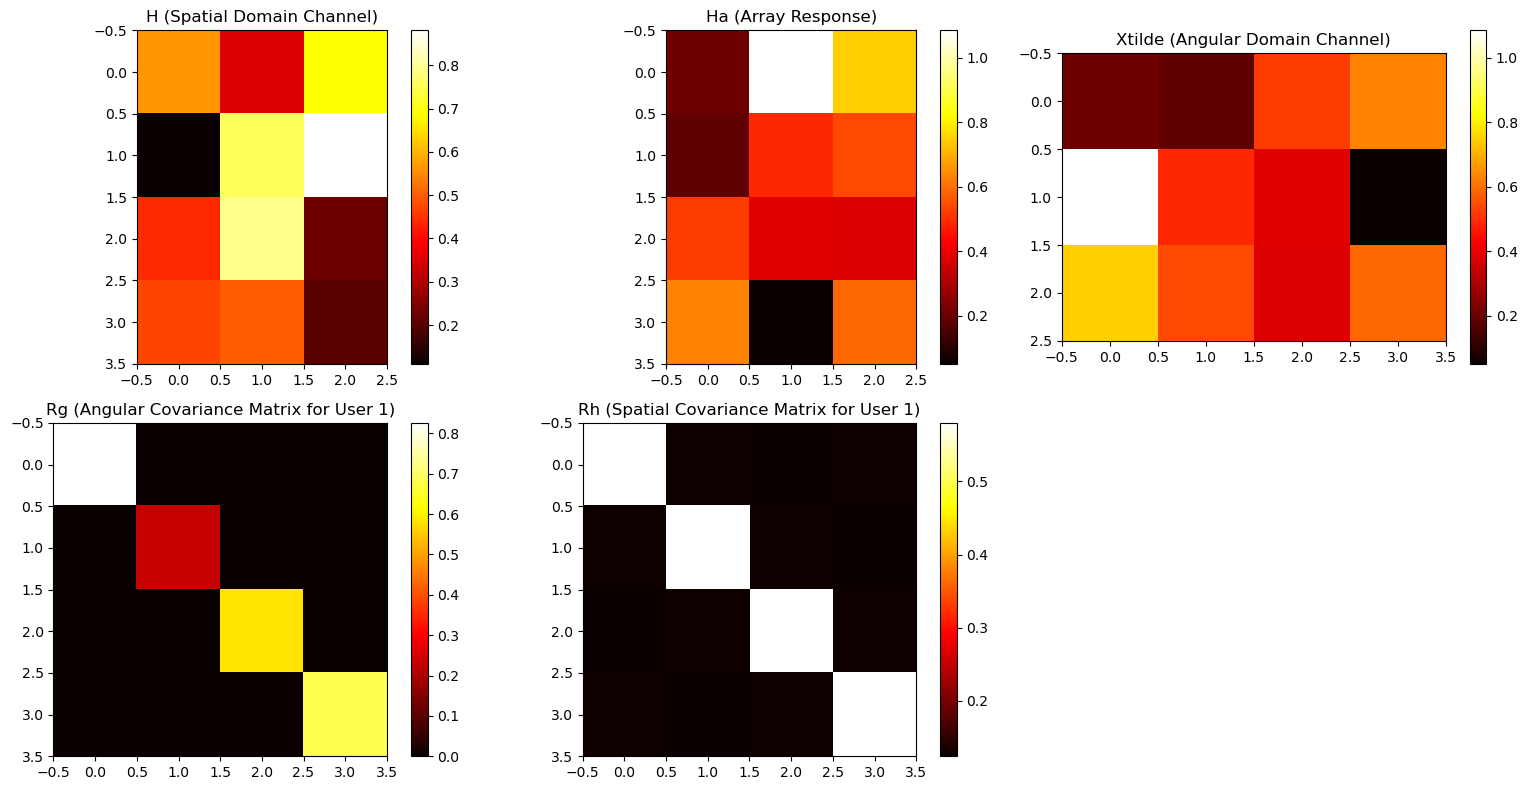

In [29]:
import matplotlib.pyplot as plt

# Define parameters
Ml = 4
N = 3
R_uniform = np.eye(Ml)
lsf = np.random.rand(N, Ml)

# Call the function
H, Ha, Xtilde, Rg, Rh = channel_generation_correlated(Ml, N, R_uniform, lsf)

# Visualize the results
plt.figure(figsize=(16, 8))

# Plot H
plt.subplot(2, 3, 1)
plt.imshow(np.abs(H), cmap='hot', interpolation='nearest')
plt.title('H (Spatial Domain Channel)')
plt.colorbar()

# Plot Ha
plt.subplot(2, 3, 2)
plt.imshow(np.abs(Ha), cmap='hot', interpolation='nearest')
plt.title('Ha (Array Response)')
plt.colorbar()

# Plot Xtilde
plt.subplot(2, 3, 3)
plt.imshow(np.abs(Xtilde), cmap='hot', interpolation='nearest')
plt.title('Xtilde (Angular Domain Channel)')
plt.colorbar()

# Plot Rg for the first user
plt.subplot(2, 3, 4)
plt.imshow(np.abs(Rg[:, :, 0]), cmap='hot', interpolation='nearest')
plt.title('Rg (Angular Covariance Matrix for User 1)')
plt.colorbar()

# Plot Rh for the first user
plt.subplot(2, 3, 5)
plt.imshow(np.abs(Rh[:, :, 0]), cmap='hot', interpolation='nearest')
plt.title('Rh (Spatial Covariance Matrix for User 1)')
plt.colorbar()

plt.tight_layout()
plt.show()

In [25]:
import numpy as np

# Set the mean and covariance matrix
mean = np.array([1 + 2j, -3 - 1j], dtype=np.complex128)  # Specify complex data type
cov_matrix = np.array([[2 + 1j, 1 - 1j], [1 + 1j, 3 - 2j]], dtype=np.complex128)  # Specify complex data type

# Generate samples
num_samples = 2
samples = np.random.multivariate_normal(np.real(mean), np.real(cov_matrix), num_samples) + 1j * np.random.multivariate_normal(np.imag(mean), np.imag(cov_matrix), num_samples)

# Print the sampled complex numbers
print("Sampled complex numbers:")
for i in range(num_samples):
    print(f"Sample {i + 1}: {samples[i]}")


C:\Users\lavku\AppData\Local\Temp\ipykernel_4396\3620180161.py:9: ComplexWarning: Casting complex values to real discards the imaginary part
  samples = np.random.multivariate_normal(mean, cov_matrix, num_samples)


UFuncTypeError: Cannot cast ufunc 'add' output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'

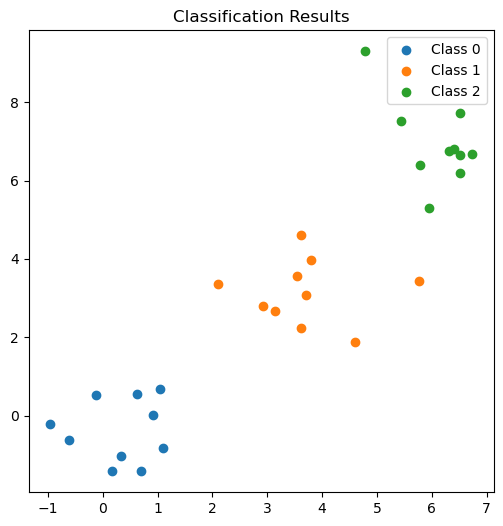

In [1]:

# Generate synthetic data for a simple classification task
def generate_data(num_classes=3, num_samples_per_class=10):
    data = []
    labels = []

    for class_idx in range(num_classes):
        class_data = np.random.randn(num_samples_per_class, 2) + 3 * class_idx
        class_labels = np.ones(num_samples_per_class) * class_idx
        data.append(class_data)
        labels.append(class_labels)

    return np.vstack(data), np.concatenate(labels)

class SimpleMAMLClassification:
    def __init__(self, config):
        self.config = config

    def train(self, num_iterations, num_inner_updates):
        # Generate synthetic data
        data, labels = generate_data()

        # MAML training loop
        for iteration in range(num_iterations):
            # Perform inner loop adaptation using MAML
            adapted_model = self.adapt_model(data, labels, num_inner_updates)

            # Visualize classification
            self.plot_classification(adapted_model, data, labels)

    def adapt_model(self, data, labels, num_inner_updates):
        # Convert data to PyTorch tensors
        data_tensor = torch.tensor(data, dtype=torch.float32)
        labels_tensor = torch.tensor(labels, dtype=torch.long)

        # Initialize model (logistic regression in this case)
        model = torch.nn.Linear(2, self.config['num_classes'])

        # Placeholder for adaptation steps (simple logistic regression - no inner loop updates)
        # ...

        return model

    def plot_classification(self, model, data, labels):
        # Convert data to PyTorch tensors
        data_tensor = torch.tensor(data, dtype=torch.float32)
        labels_tensor = torch.tensor(labels, dtype=torch.long)

        # Perform classification using the adapted model
        with torch.no_grad():
            logits = model(data_tensor)
            predictions = torch.argmax(logits, dim=1).numpy()

        # Plot the classification results
        plt.figure(figsize=(6, 6))
        for class_idx in range(self.config['num_classes']):
            class_data = data[labels == class_idx]
            plt.scatter(class_data[:, 0], class_data[:, 1], label=f'Class {class_idx}')

        plt.title('Classification Results')
        plt.legend()
        plt.show()

# Example usage:
config = {
    'num_classes': 3,
    # Add more configuration parameters as needed
}

# Initialize SimpleMAMLClassification
simple_maml_classifier = SimpleMAMLClassification(config)

# Train the MAML model and plot classification results
simple_maml_classifier.train(num_iterations=1, num_inner_updates=0)  # Adjust num_iterations and num_inner_updates as needed


In [1]:
import pickle
import matplotlib.pyplot as plt
import numpy as np
import torch

In [2]:
with open('./offline_realistic/meta_train_set/input_set.pckl', 'rb') as file:
    data1 = pickle.load(file)
data1.shape

torch.Size([1000, 3200, 4])

In [3]:
with open('./offline_realistic/meta_train_set/channel_set.pckl', 'rb') as file:
    data2 = pickle.load(file)
data2.shape

torch.Size([1000, 2])

In [4]:
with open('./offline_realistic/meta_train_set/non_linear_set.pckl', 'rb') as file:
    data3 = pickle.load(file)
data3.shape

torch.Size([1000, 2])

In [11]:
print(data1[0,0:10],data2[0],data3[0])

tensor([[-3.0000, -3.0000, -3.0286, -1.6459],
        [-3.0000,  1.0000, -3.6428,  2.2231],
        [ 1.0000,  1.0000,  0.8797,  0.3728],
        [ 1.0000, -3.0000,  1.7412, -3.4521],
        [-3.0000,  3.0000, -3.7144,  4.5116],
        [ 3.0000,  1.0000,  2.9745, -0.2993],
        [ 1.0000, -1.0000,  1.3428, -0.8985],
        [-1.0000, -3.0000, -0.8953, -2.7328],
        [ 3.0000,  3.0000,  2.9055,  2.1364],
        [ 3.0000, -1.0000,  3.5003, -2.1014]]) tensor([ 1.1089, -0.1905]) tensor([0.1038, 0.2381])


In [14]:
device = torch.device('cuda')

In [16]:
def generating_channel(var_array, device_for_data):  # channel (rayleigh)
    device = device_for_data
    h = torch.empty(len(var_array), 2)
    # h = [-1,0]
    for i in range(len(var_array)):
        Chan = torch.distributions.multivariate_normal.MultivariateNormal(torch.zeros(2), var_array[i] * torch.eye(2))
        h_tmp = Chan.sample()
        h[i] = h_tmp
    h = h.to(device)
    return h
def generating_symbol(M, device_for_data):
    device = device_for_data
    Bern = torch.distributions.bernoulli.Bernoulli(torch.tensor([0.5]))  # equal prob.
    if M == 2:  # BPSK
        symb = Bern.sample()
        symb = symb.to(device)
        if symb == 0:
            symb = -1
        symb = torch.FloatTensor([symb, 0])
    elif M == 4:  # 4-QAM
        symb1 = Bern.sample()
        symb2 = Bern.sample()
        symb1 = symb1.to(device)
        symb2 = symb2.to(device)
        if symb1 == 0:
            symb1 = -1
        if symb2 == 0:
            symb2 = -1
        symb = torch.FloatTensor([symb1, symb2])
    elif M == 5:  # 4-PAM
        symb1 = Bern.sample()
        symb2 = Bern.sample()
        symb1 = symb1.to(device)
        symb2 = symb2.to(device)
        if symb1 == 0:
            symb1 = -1
        if symb2 == 0:
            symb2 = -1
        symb1 = symb1 * 2
        symb = torch.FloatTensor([symb1 + symb2, 0])  # -3, -1,, 1, 3 : 4-PAM
    elif M == 16:  # 16-QAM
        symb1 = Bern.sample()
        symb2 = Bern.sample()
        symb3 = Bern.sample()
        symb4 = Bern.sample()
        symb1 = symb1.to(device)
        symb2 = symb2.to(device)
        symb3 = symb3.to(device)
        symb4 = symb4.to(device)
        if symb1 == 0:
            symb1 = -1
        if symb2 == 0:
            symb2 = -1
        if symb3 == 0:
            symb3 = -1
        if symb4 == 0:
            symb4 = -1
        symb3 = symb3 * 2
        symb4 = symb4 * 2
        symb = torch.FloatTensor([symb1 + symb3, symb2 + symb4])
    else:
        NotImplementedError()
    symb = symb.to(device)
    return symb
def generating_noise_dist(var):
    Noise = torch.distributions.multivariate_normal.MultivariateNormal(torch.zeros(2), var * torch.eye(2))
    return Noise
def iq_imbalance(s, epsilon, delta, device):
    s = s.to(device)
    s_distorted = torch.FloatTensor([0, 0])
    s_distorted = s_distorted.to(device)
    s_distorted[0] = (1 + epsilon) * torch.cos(delta) * s[0] - (1 + epsilon) * torch.sin(delta) * s[1]
    s_distorted[1] = (1 - epsilon) * torch.cos(delta) * s[1] - (1 - epsilon) * torch.sin(delta) * s[0]
    return s_distorted

In [ ]:
def generating_training_set(curr_dev_char, K_TR, K_TE, num_dev, M, var_array, var, mean_array0, mean_array1,
                             power, device):
    ## generating training dataset
    train_set = torch.zeros(num_dev, K_TR + K_TE, 4)  # 4 = 2+2, s and y
    train_set = train_set.to(device)

    channel_set_for_vis = torch.zeros(num_dev, 2)
    channel_set_for_vis = channel_set_for_vis.to(device)

    non_linearity_set_genie = torch.zeros(num_dev, 2)
    non_linearity_set_genie = non_linearity_set_genie.to(device)

    if curr_dev_char is None:
        print(
            'in meta-training, we are generating new channel and distortion for test (if you are in online, something wrong!!!!')
        h = generating_channel(var_array, device)
        l_0 = mean_array0
        l_1 = mean_array1
    else:
        h = curr_dev_char[0]
        l_0 = curr_dev_char[1]
        l_1 = curr_dev_char[2]

    for ind_d in range(num_dev):
        print('curr dev', ind_d)
        for i in range(K_TR + K_TE):
            s_tmp = generating_symbol(M, device)
            
            train_set[ind_d, i, :2] = s_tmp  # generating symbol # original constellation point without distortion
            Noise = generating_noise_dist(var)
            n = Noise.sample()
            n = n.to(device)
            
            s_tmp = iq_imbalance(s_tmp, l_0[ind_d], l_1[ind_d], device)
            s_tmp[0] = s_tmp[0] * power
            s_tmp[1] = s_tmp[1] * power
        
            train_set[ind_d, i, 2] = h[ind_d][0] * s_tmp[0] - h[ind_d][1] * s_tmp[1]
            train_set[ind_d, i, 3] = h[ind_d][0] * s_tmp[1] + h[ind_d][1] * s_tmp[0]
            train_set[ind_d, i, 2:] = train_set[ind_d, i, 2:] + n  # adding noise
            
    return train_set, channel_set_for_vis, non_linearity_set_genie



In [ ]:
basic_distribution_for_amplitude = torch.distributions.beta.Beta(5, 2) # between 0 and 1
basic_distribution_for_phase = torch.distributions.beta.Beta(5, 2) # between 0 and 1

mean_array0 = []
mean_array1 = []
for ind_dev_meta_train in range(num_dev):
    ampl_beta_rv = basic_distribution_for_amplitude.sample()
    phase_beta_rv = basic_distribution_for_phase.sample()
    ampl_distortion_curr_dev = ampl_beta_rv * 0.15  # we need to multiply with max value: 0.15
    phase_distortion_curr_dev = phase_beta_rv * (numpy.pi / 180) * 15 # 15 degree
    mean_array0.append(ampl_distortion_curr_dev)
    mean_array1.append(phase_distortion_curr_dev)

In [90]:
i = torch.randint(0,1000,())

x = data[i][:,2:4]

labels = data[i][:,0:2]
y = encode_labels(labels[:,0],labels[:,1])

In [88]:
labels = data[1][:,0:2]

In [89]:
def encode_labels(a: int, b: int) -> int:
    """Encode pair (a, b) into a unique numerical label"""
    mapping = {(-3, -3): 0, (-3, -1): 1, (-3, 1): 2, (-3, 3): 3,
               (-1, -3): 4, (-1, -1): 5, (-1, 1): 6, (-1, 3): 7,
               (1, -3): 8, (1, -1): 9, (1, 1): 10, (1, 3): 11,
               (3, -3): 12, (3, -1): 13, (3, 1): 14, (3, 3): 15}
    
    pairs = torch.stack((a, b), dim=1)
    encoded_labels = torch.tensor([mapping[tuple(pair.tolist())] for pair in pairs])

    return encoded_labels
enlab = encode_labels(labels[:,0],labels[:,1])

In [87]:
enlab.shape

torch.Size([3200])

(array([400., 200., 400., 200., 400., 200., 400., 200., 400., 400.]),
 array([ 0. ,  1.5,  3. ,  4.5,  6. ,  7.5,  9. , 10.5, 12. , 13.5, 15. ]),
 <BarContainer object of 10 artists>)

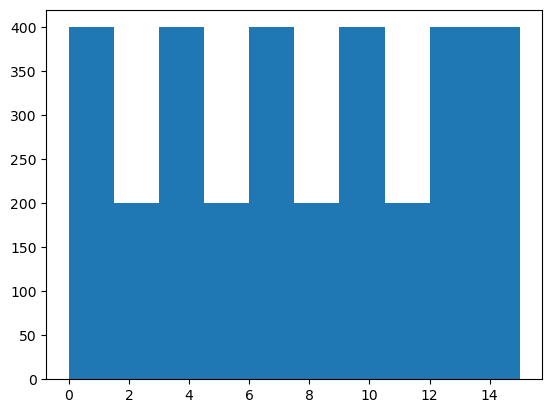

In [91]:
plt.hist(y)

In [25]:
import numpy as np
from scipy.special import jv

x = 110*2*3.141*1e-5*20*2e9/2.998e8  # the value of x at which to calculate the Bessel function
#speed of light using numpy


bessel_0 = jv(0, x)
print(bessel_0)


0.7985176668231244


In [1]:
t = torch.FloatTensor([torch.randint(0, 4, ()) * 0.2 +0.2])

NameError: name 'torch' is not defined